# Weighting field of a planar sensor
This example demonstrates the concept of weighting fields that determine the signal generation at the electrode. It has been described by Shockley and Ramo in 1938 and 1939, respectively. SOURCE
In short, the individual motion of the charges (electrons and holes) produced by ionizing radiation induces an instantaneous current in the readout electrode.

## Mathematical treatment
The Shockley-Ramo theorem states for the induced current $i$ in a one-dimensional case:
$$
i = q\,E_w\,v_D
$$
with $q$ the charge, $v_D$ its velocity and $E_w$ the weighting field. The latter defines how much current is induced on the electrode under consideration. $E_w$ corresponds to the electric field at the location of the electron or hole when unit potential is applied on the respective electrode while all others are set to $0$ and the charge $q$ would not be present.

In case of multiple electrodes (denoted by index $n$), the formula above can be generalized to:
$$
i_n = q\,\vec{E}_{w,n}\,\vec{v}_D\:.
$$
The drift velocity is defined as $\vec{v}_D = \mu({\vec{E}})\cdot\vec{E}$ with $\mu$ the mobility of the charge carrier. **Note**: in scarce2, we neglect the small dependency of the mobility on the electric field (and temperature).
For silicon at room temperature we will use: SOURCE
$$
\mu_e \approx 1400\,\frac{\mathrm{cm}}{\mathrm{V\,s}}\quad and\quad \mu_h \approx 500\,\frac{\mathrm{cm}}{\mathrm{V\,s}}\:.
$$

## The weighting potential
The weighting field can be expressed in terms of a potential according to:
$$
\vec{E}_{w,n} = -\vec{\nabla}\phi_{w,n}
$$
where $\phi_{w,n}$ denotes the weighting potential. It obeys the Laplace equation and can be calculated by setting the potential at the electrode $n$ to unit potential ($= 1$) and the potential at all other electrodes to $0$.

## Calculating the weighting potential
$\phi_{w,n}$ can be calculated by solving the Laplace equation:
$$
\Delta\phi_{w,n} = 0\:
$$
using appropriate boundary conditions as mentioned in the section *The weighting potential*. While an analytical solution is possible depending on the specific case, we will use `fipy`, a python package for solving partial differential equations using a finite volume approach.

### Setting up the geometry
As a first step, we import the `scarce2` package and define basic features of our sensor: the number of pixels, their size, the size of the readout electrode and the thickness of the device. Since only the central electrode is considered in `scarce2`, the number of pixels must be odd and should be at least 5 for proper results.
The size of the electrode must be smaller than the pixel size. In its current state, only fully depleted sensors are supported, otherwise you will get inconclusive results. Please choose the geometrical parameters from a reasonable range (i.e. pixel size and thickness in the order of a few ten to a few hundred micrometers).

After the sensor object has been instantiated with the given geometry, we generate the mesh on which the Laplace equation is solved using the tool `gmsh`. A higher mesh density increases the accuracy at the cost of significantly longer runtime for the finite volume solver. Exact values depend on the geometry and your machine. It is recommended to start with a small mesh density, possibly below 1 (but larger than 0) and increase it gradually.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scarce2.sensor import Sensor
from scarce2 import plotting
from scarce2 import signals  # required for charge propagation

# All dimensions are given in units of um
s = Sensor(n_pixel=7, pitch=50, electrode_size=40, thickness=150)
s.generate_mesh(mesh_density=1)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00337542s, CPU 0.003799s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.243451s, CPU 0.239905s)
Info    : 14567 nodes 29140 elements
Info    : Writing '/tmp/mesh.msh2'...
Info    : Done writing '/tmp/mesh.msh2'


The complete `gmsh` program is shipped with the installation which allows you to visualize the mesh within a graphical window by calling `gmsh /tmp/mesh.msh2`. The mesh for this example looks like this:
![Example mesh](mesh_example.png "Example mesh")

### Solving the Laplace equation
Since the boundary conditions when solving for the weighting potential are defined regardless of the geometry and bias voltage, we do not need to pass any parameters. As mentioned before, solving can take some time if the mesh density is too high. If it takes longer than a minute, you should reduce the mesh density until you end up in a runtime that matches your patience.

We can visualize the weighting potential with plotting tools included in `scarce2`. The `plot_potential` function takes the potential and number of pixels as arguments. The latter is used to determine the figure size such that it matches the size and aspect ratio of the defined sensor.
The horizontal axis is centered in the middle of the central electrode and the vertical axis has its origin defined at the backplane (opposite of the readout electrodes).

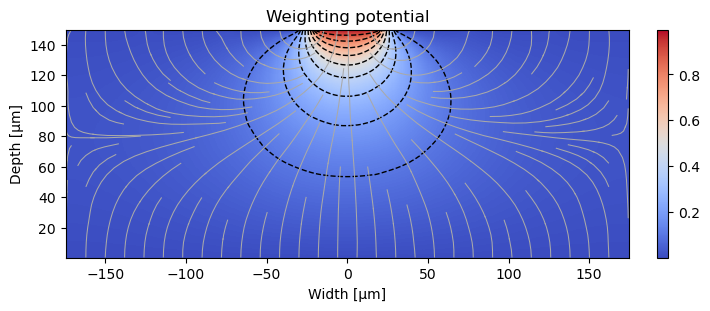

In [2]:
s.setup_w_potential()
s.solve_w_potential()
plotting.plot_potential(s.w_potential, n_pixel=s.n_pixel, plot_title="Weighting potential")

## Calculating the collected charge
Using the relationship
$$
\mathrm{d}Q = i\,\mathrm{d}t\:\mathrm{,}
$$
we can write:
$$\begin{aligned}
\mathrm{d}Q &= q\,\vec{E}_{w,n}\,\vec{v_D}\,\mathrm{d}t\\
&=q\,\vec{E}_{w,n}\,\mathrm{d}\vec{x}
\end{aligned}
$$
to calculate the induced charge $\mathrm{d}Q$ per time step $\mathrm{d}t$ by propagating from point $vec{x}_1$ to $\vec{x}_2$ according to $\mathrm{d}\vec{x} = \vec{x}_2 - \vec{x}_1$.
From its initial position $\vec{x}_1$, $\vec{x}_2$ can be calculated as follows:
$$\vec{x}_2 = \vec{x}_1 + \vec{v}_D \cdot \mathrm{d}t\quad\Rightarrow\quad\mathrm{d}\vec{x} = \vec{v}_D \cdot \mathrm{d}t.$$

At this time, we need information about the electric field in the sensor as well, since $\vec{v}_D$ is a function of $\vec{E}$. Another example demonstrates how it can be obtained using `scarce2`. The solution is stored in the `sensor` object as well which allows us to easily combine weighting field and electric field in order to calculate the induced charge.

In [16]:
# We need the electric field to propagate the electrons/holes. For details, see the example electric_field.iypnb
s.setup_e_potential()
s.solve_e_potential(V_bias=-100)
s.convert_to_numpy()  # Generate meshgrids for both fields to use fast numpy functions for further analysis

### Propagation of a single electron hole pair

`scarce2` provides a module for electron hole pair propagation. We will make use of the function `collected_charge_vs_time()` that takes care of calculating the electric field at the charge carriers position, its movement in the sensor and finally the induced charge. The propagation stops when a charge carrier reached the boundaries of the given sensor.

In [17]:
initial_pos = (0, 50)  # horizontally centered below readout electrode, 50 um above backplane
timestep = 0.001  # units of ns
charge = signals.collected_charge_vs_time(sensor=s, initial_pos=initial_pos, timestep=timestep)

The return value `charge` is a dictionary with the induced charge per time step for both electrons and holes. Due to different mobility and based on the initial position, the propagation time differs for electrons and holes. After they reached the boundaries of the sensor and their movement (in simulation) stops they do not induce any charge. For visualization purposes, we can append zeros to the individual data such that they match in length. We will also calculate the absolute time based on the given time step and amount of data points.

In [18]:
charge_e, charge_h = charge["electrons"], charge["holes"]

# Fill shorter array with last value for display reasons and total charge
if len(charge_e) > len(charge_h):
    charge_h = np.concatenate((charge_h, np.repeat(0, len(charge_e) - len(charge_h))))
elif len(charge_h) > len(charge_e):
    charge_e = np.concatenate((charge_e, np.repeat(0, len(charge_h) - len(charge_e))))

if len(charge_e) != len(charge_h):
    raise RuntimeError("Charge arrays have different length!")

abs_time = np.linspace(0, len(charge_e) * timestep, len(charge_e))


In a next step, we will build the cumulative sum for each type of charge carrier to see how much charge is induced over time.

In [19]:
abs_charge_e = np.cumsum(charge_e)
abs_charge_h = np.cumsum(charge_h)

Finally, we will plot the data individually and the sum of electrons and holes since both contribute to the signal generation. Our result only reflects a single electron hole pair. Therefore, the total induced charge should equal to 1 at the end of the propagation, which we can observe in the figure.

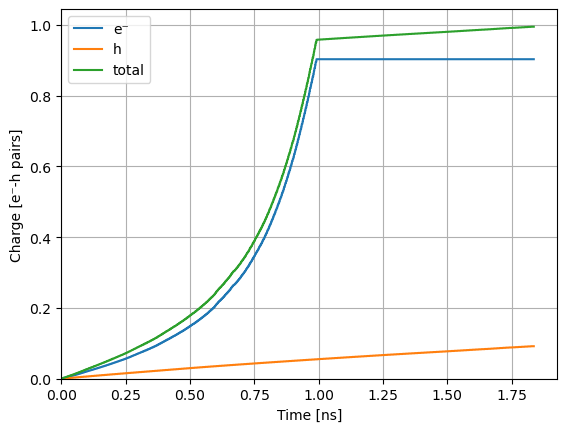

In [20]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(abs_time, abs_charge_e, '-', label="e⁻")
ax.plot(abs_time, abs_charge_h, '-', label="h")
ax.plot(abs_time, abs_charge_e + abs_charge_h, '-', label="total")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Charge [e⁻-h pairs]")
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.legend(loc="upper left")
plt.show()

The total time until the charge is collected is about 1.8 ns. The steep rise of the contribution from the electrons is due to their larger mobility (about a factor three) and the stronger weighting field close to the electrode to which they propagate. Since holes move towards to more negative potential, they propagate to the backside of the sensor where the weighting field is significantly lower.

## Conclusion
This example explains the basic concept of the weighting field and a demonstration on how to investigate the weighting field and signal generation of simple sensor structures with `scarce2`. It serves as a starting point for playing around with the model parameters to study effects of varying bias voltage and geometry.

After following the example, you should be able to find an explanation for the generated signal when changing the initial position of the electron hole pair to another point below the collection electrode and/or moving it laterally in the sensor.